## Image Processing for Transfer Learning 

 * Select Subset of Dataframe for glasses, hats, and beard one vs rest classifier 
 * split into train and test df for model training 
 * view images after keras_preprocessing.image ImageDataGenerator
---

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [2]:
# load dataframe
df_pics = pd.read_pickle('../pickle_files/pic_df.pkl')
df_pics.head(2)

,eyewear,hat,beard
00018.jpg,0,0,1
00034.jpg,0,0,1


### Select DataFrame based upon label of interest 

 * balance out class labels to roughly 50:50 
 * use np.random.choice to downsample the majority class 

In [3]:
def class_balance(df, label):
    '''
    inputs:
    df: df_pics from the original pic_label dataframe
    label: label of interest for classification such as no glasses or glasses, a string
    output:
    dataframe with 0 and 1 balanced 
    '''
    np.random.seed(16) # make it reproducible
    sub_df = df_pics[[label]]
    index_0 = sub_df[sub_df[label]==0].index.tolist() # 0_df 
    index_1 = sub_df[sub_df[label]==1].index.tolist()  # 1_df 
    num_0 , num_1 = len(index_0), len(index_1)
    # if more 1 than 0 then downsample 1, vice versa
    if num_0 < num_1:
        chosen_1 = np.random.choice(index_1, replace=False, size=num_0) # choose 1 label with same count as 0 
        inds = index_0+list(chosen_1)
    else:
        chosen_0 = np.random.choice(index_0, replace=False, size=num_1) # choose 0 label with same count as 1
        inds = index_1+list(chosen_0)
    return sub_df.loc[inds]

In [6]:
glasses_df = class_balance(df_pics, 'eyewear')
hats_df = class_balance(df_pics, 'hat')
beard_df = class_balance(df_pics,'beard')

### Get dataframe compatible for image generator 

In [7]:
# turn 0 and 1 into string for flow_from_dataframe in image generator 
def dataframe_processor(df, label):
    '''
    inputs:
    df: dfs created from class_balance function
    label: eyewear, hat, or beard, a string 
    return:
    a dataframe compatible for image generator flow_from_dataframe
    '''
    # colvalue needs to be string for binary classification
    map_dict = {0:'not_'+label, 1:label}
    df_1=df.copy()
    df_1[label]=df[label].map(map_dict)
    # require index column to be an actual colname 
    df_1.reset_index(inplace=True)
    df_1.rename(columns = {'index':'pic_id'}, inplace = True)
    return df_1

In [8]:
# for flow_dataframe:
glasses_df = dataframe_processor(glasses_df,'eyewear')
hats_df = dataframe_processor(hats_df,'hat')
beard_df = dataframe_processor(beard_df, 'beard')

In [9]:
glasses_df.eyewear.value_counts()

not_eyewear    316
eyewear        316
Name: eyewear, dtype: int64

In [10]:
hats_df.hat.value_counts()

hat        255
not_hat    255
Name: hat, dtype: int64

In [11]:
beard_df.beard.value_counts()

beard        227
not_beard    227
Name: beard, dtype: int64

### split into X_train, X_test and concatenate for image generator 

In [12]:
def train_test_df(df, test_size, label):
    '''
    inputs:
    df: dfs created from dataframe_processor 
    test_size: a float, 0.2 or 0.3 or < 1
    label: a string, eyewear, hat, beard 
    returns:
    test and train dataframes, train first, then test second 
    '''
    # 20% test and 80% train 
    X_train, X_test, y_train, y_test = train_test_split(df['pic_id'], 
                                                        df[label],
                                                        stratify = df[label],
                                                        random_state = 16, test_size = test_size)
    # split into train and test dataframes 
    train_df = pd.DataFrame({'pic_id':X_train, label:y_train})
    test_df = pd.DataFrame({'pic_id':X_test, label:y_test})
    return train_df, test_df 

In [13]:
train_df_glass, test_df_glass = train_test_df(glasses_df, 0.2, 'eyewear')
train_df_hat, test_df_hat = train_test_df(hats_df, 0.2, 'hat')
train_df_beard, test_df_beard = train_test_df(beard_df, 0.2, 'beard')

In [16]:
display(train_df_glass.eyewear.value_counts())

test_df_glass.eyewear.value_counts()

eyewear        253
not_eyewear    252
Name: eyewear, dtype: int64

not_eyewear    64
eyewear        63
Name: eyewear, dtype: int64

In [17]:
display(train_df_hat.hat.value_counts())

test_df_hat.hat.value_counts()

hat        204
not_hat    204
Name: hat, dtype: int64

hat        51
not_hat    51
Name: hat, dtype: int64

In [18]:
display(train_df_beard.beard.value_counts())

test_df_beard.beard.value_counts()

beard        182
not_beard    181
Name: beard, dtype: int64

not_beard    46
beard        45
Name: beard, dtype: int64

### Create Image generator and look at pictures 

In [25]:
# data preprocess and data agumentation to help with small data set
def image_generation(train_df, test_df, label, batch_size):
    '''
    inputs:
    train_df and test_df: created from train_test_df function
    label: a string, eyewear, hat, or beard 
    batch_size: process images in batches 
    returns:
    image generators for train and test for visual inspection 
    '''
    # use imagedatageneraor to preprocess and augment the small dataset 
    datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
    # preprocess both train and test 
    train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col= label,
    batch_size=batch_size,
    seed = 36,
    shuffle = True,
    target_size=(150,150),
    class_mode = 'binary')
    
    test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    seed = 24,
    shuffle = True,
    target_size=(150,150),
    class_mode = 'binary')
    
    return train_generator, test_generator    

In [31]:
# checkout some images 
train_glass, test_glass = image_generation(train_df_glass, test_df_glass,'eyewear', 32)

Found 505 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.


In [36]:
# checkout some images 
train_hat, test_hat = image_generation(train_df_hat, test_df_hat,'hat', 32)

Found 408 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


In [39]:
# checkout some images 
train_beard, test_beard = image_generation(train_df_beard, test_df_beard,'beard', 32)

Found 363 validated image filenames belonging to 2 classes.
Found 91 validated image filenames belonging to 2 classes.


In [27]:
def show_imgs(data_gen, num, batch_size):
    '''
    input:
    data_gen: from image_generation function
    num: number of pictures to view 
    batch_size: consistent in image_generation function
    output:
    images of processed images
    '''
    random_images = np.random.choice(range(batch_size),num)
    x, y = next(data_gen)
    for image in random_images:
        plt.imshow(x[image])
        plt.show()

### view 10 random images

---

### Train

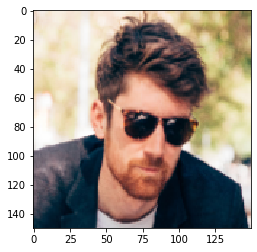

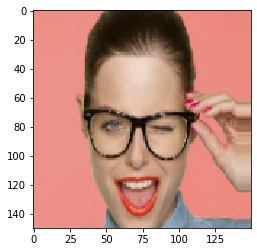

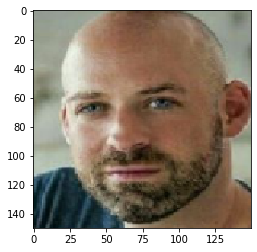

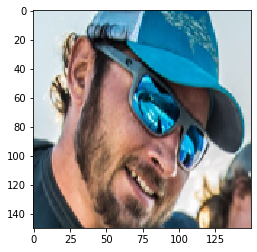

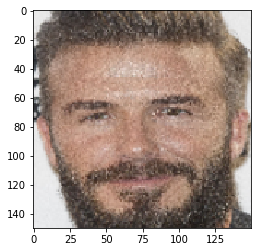

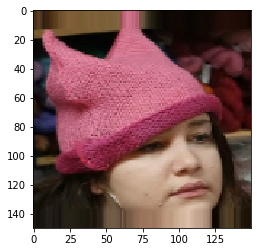

In [40]:
show_imgs(train_beard, 6, 32)

----
### Test

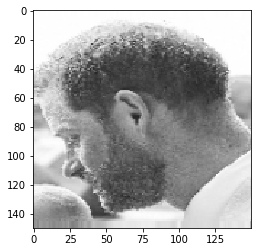

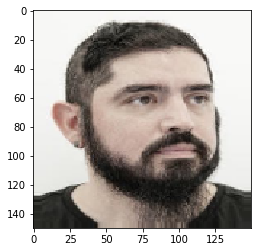

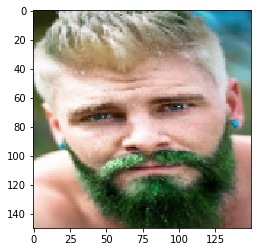

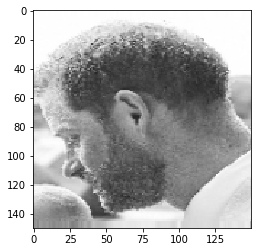

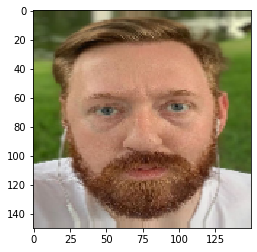

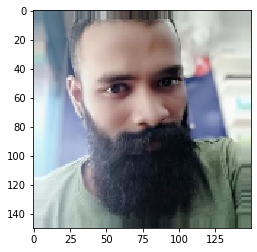

In [41]:
show_imgs(test_beard,6,32)

### Save Train and Test DataFrames for model Tuning

In [42]:
# save train_test_df 
train_df_glass.to_pickle('../pickle_files/train_df_glasses.pkl')
test_df_glass.to_pickle('../pickle_files/test_df_glasses.pkl')
train_df_hat.to_pickle('../pickle_files/train_df_hat.pkl')
test_df_hat.to_pickle('../pickle_files/test_df_hat.pkl')
train_df_beard.to_pickle('../pickle_files/train_df_beard.pkl')
test_df_beard.to_pickle('../pickle_files/test_df_beard.pkl')